###### The latest version of this IPython notebook is available at [http://github.com/jckantor/ESTM60203](http://github.com/jckantor/ESTM60203)  for noncommercial use under terms of the [Creative Commons Attribution Noncommericial ShareAlike License (CC BY-NC-SA 4.0)](http://creativecommons.org/licenses/by-nc-sa/4.0/).

J.C. Kantor (Kantor.1@nd.edu)

# Newsvendor Problem

This [Jupyter notebook](http://jupyter.org/notebook.html) demonstrates the formulation and solution of the well-known "Newsvendor Problem" using GLPK/Mathprog and Gurobi Python.

## Background

The newsvendor problem is a two stage decision problem with recourse. The vendor needs to decide how much inventory to order today to fulfill an uncertain demand. The data includes the unit cost, price, and salvage value of the product being sold, and a probabilistic forecast of demand. The objective is to maximize expected profit.

As shown in lecture, this problem can be solved with a plot, and the solution interpreted in terms of a cumulative probability distribution. The advantage of a MathProg model is that additional constraints or other criteria may be considered, such as risk aversion.
    
There is an extensive literature on the newsvendor problem which has been  studied since at least 1888. See <a rel="external" href="http://www.isye.umn.edu/courses/ie5551/additional%20materials/newsvendort.pdf">here</a> for a thorough discussion.

In [23]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gurobipy import *

## MathProg Solution

In [25]:
%%script glpsol -m /dev/stdin

# Example: Newsvendor.mod

/* Unit Price Data */
param r >= 0;                              # Price
param c >= 0;                              # Cost
param w >= 0;                              # Salvage value

/* Price data makes sense only if  Price > Cost > Salvage */
check: c <= r;
check: w <= c;

/* Probabilistic Demand Forecast */
set SCENS;                                 # Scenarios
param D{SCENS} >= 0;                       # Demand
param Pr{SCENS} >= 0;                      # Probability

/* Probabilities must sum to one. */
check: sum{k in SCENS} Pr[k] = 1;

/* Expected Demand */
param ExD := sum{k in SCENS} Pr[k]*D[k];

/* Lower Bound on Profit: Expected Value of the Mean Solution */
param EVM := -c*ExD + sum{k in SCENS} Pr[k]*(r*min(ExD,D[k])+w*max(ExD-D[k],0));

/* Upper Bound on Profit: Expected Value with Perfect Information */
param EVPI := sum{k in SCENS} Pr[k]*(r-c)*D[k];

/* Two Stage Stochastic Programming */
var x >= 0;                     # Stage 1 (Here and Now): Order Quqntity
var y{SCENS}>= 0;               # Stage 2 (Scenario Dep): Actual Sales
var ExProfit;                   # Expected Profit

/* Maximize Expected Profit */
maximize OBJ: ExProfit;

/* Goods sold are limited by the order quantities and the demand  */
s.t. PRFT: ExProfit = -c*x + sum{k in SCENS} Pr[k]*(r*y[k] + w*(x-y[k]));
s.t. SUPL {k in SCENS}: y[k] <= x;
s.t. DMND {k in SCENS}: y[k] <= D[k];

solve;

table Table_EVM {k in SCENS} OUT "CSV" "evm.csv" "Table":
   k~Scenario,
   Pr[k]~Probability, 
   D[k]~Demand, 
   ExD~Order, 
   min(ExD,D[k])~Sold,
   max(ExD-D[k],0)~Salvage, 
   -c*ExD + r*min(ExD,D[k]) + w*max(ExD-D[k],0)~Profit;
   
table Table_EVPI {k in SCENS} OUT "CSV" "evpi.csv" "Table":
   k~Scenario,
   Pr[k]~Probability, 
   D[k]~Demand, 
   D[k]~Order, 
   D[k]~Sold,
   0~Salvage, 
   -c*D[k] + r*D[k]~Profit;
   
table Table_SP {k in SCENS} OUT "CSV" "evsp.csv" "Table":
   k~Scenario,
   Pr[k]~Probability, 
   D[k]~Demand, 
   x~Order, 
   y[k]~Sold,
   x-y[k]~Salvage, 
   -c*x + r*y[k] + w*(x-y[k])~Profit;

data;

/* Problem Data corresponds to a hypothetical case of selling programs prior 
to a home football game. */

param r := 10.00;                         # Unit Price
param c :=  6.00;                         # Unit Cost
param w :=  2.00;                         # Unit Salvage Value

param: SCENS:  Pr    D   :=
       HiDmd   0.25  250
       MiDmd   0.50  125
       LoDmd   0.25   75 ;

end;

GLPSOL: GLPK LP/MIP Solver, v4.60
Parameter(s) specified in the command line:
 -m /dev/stdin
Reading model section from /dev/stdin...
Reading data section from /dev/stdin...
86 lines were read
Checking (line 10)...
Checking (line 11)...
Checking (line 19)...
Generating OBJ...
Generating PRFT...
Generating SUPL...
Generating DMND...
Model has been successfully generated
GLPK Simplex Optimizer, v4.60
8 rows, 5 columns, 15 non-zeros
Preprocessing...
3 rows, 4 columns, 6 non-zeros
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 3
*     0: obj =  -0.000000000e+00 inf =   0.000e+00 (3)
*     5: obj =   4.000000000e+02 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Time used:   0.0 secs
Memory used: 0.1 Mb (142447 bytes)
Writing Table_EVM...
Writing Table_EVPI...
Writing Table_SP...
Model has been successfully processed


### Expected Value for the Mean Scenario (EVM)

In [26]:
evm = pd.read_csv("evm.csv")
print(evm)

ev_evm = sum(evm['Probability']*evm['Profit'])
print("Expected Value for the Mean Scenario = {:6.2f}".format(ev_evm))

  Scenario  Probability  Demand   Order    Sold  Salvage  Profit
0    HiDmd         0.25     250  143.75  143.75     0.00     575
1    MiDmd         0.50     125  143.75  125.00    18.75     425
2    LoDmd         0.25      75  143.75   75.00    68.75      25
Expected Value for the Mean Scenario = 362.50


### Expected Value with Perfect Information (EVPI)

In [27]:
evpi = pd.read_csv("evpi.csv")
print(evpi)

ev_evpi = sum(evpi['Probability']*evpi['Profit'])
print("Expected Value with Perfect Information = {:6.2f}".format(ev_evpi))

  Scenario  Probability  Demand  Order  Sold  Salvage  Profit
0    HiDmd         0.25     250    250   250        0    1000
1    MiDmd         0.50     125    125   125        0     500
2    LoDmd         0.25      75     75    75        0     300
Expected Value with Perfect Information = 575.00


### Expected Value by Stochastic Programming

In [28]:
evsp = pd.read_csv("evsp.csv")
print(evsp)

ev_evsp = sum(evsp['Probability']*evsp['Profit'])
print("Expected Value by Stochastic Programming = {:6.2f}".format(ev_evsp))

  Scenario  Probability  Demand  Order  Sold  Salvage  Profit
0    HiDmd         0.25     250    125   125        0     500
1    MiDmd         0.50     125    125   125        0     500
2    LoDmd         0.25      75    125    75       50     100
Expected Value by Stochastic Programming = 400.00


### Value of Perfect Information

In [29]:
print("Value of Perfect Information = {:6.2f}".format(ev_evpi-ev_evsp))

Value of Perfect Information = 175.00


### Value of the Stochastic Solution

In [30]:
print("Value of the Stochastic Solution = {:6.2f}".format(ev_evsp-ev_evm))

Value of the Stochastic Solution =  37.50


## Plot of Expected Profit as function of Order Size

TypeError: float() argument must be a string or a number, not 'function'

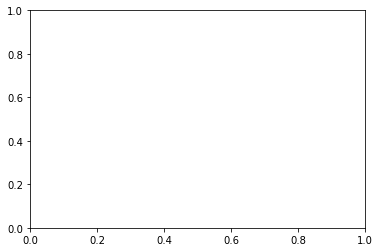

In [37]:
r = 1.00
c = 0.60
w = 0.25

scenarios = [['Low Demand',75,.25],['High Demand',200,.75]]

def profit(D,x):
    return r*min([D,x]) + w*max([0,x-D]) - c*x



def exprofit(x):
    v = 0
    for s in scenarios:
        v += s[2]*profit(s[1],x)
    return profit(04)

x = np.linspace(0,400,400)
plt.plot(x,[exprofit(xx) for xx in x])
plt.xlabel('Order size')
plt.ylabel('Expected Profit')



In [38]:
[exprofit(x) for x in x]

[<function __main__.profit>,
 <function __main__.profit>,
 <function __main__.profit>,
 <function __main__.profit>,
 <function __main__.profit>,
 <function __main__.profit>,
 <function __main__.profit>,
 <function __main__.profit>,
 <function __main__.profit>,
 <function __main__.profit>,
 <function __main__.profit>,
 <function __main__.profit>,
 <function __main__.profit>,
 <function __main__.profit>,
 <function __main__.profit>,
 <function __main__.profit>,
 <function __main__.profit>,
 <function __main__.profit>,
 <function __main__.profit>,
 <function __main__.profit>,
 <function __main__.profit>,
 <function __main__.profit>,
 <function __main__.profit>,
 <function __main__.profit>,
 <function __main__.profit>,
 <function __main__.profit>,
 <function __main__.profit>,
 <function __main__.profit>,
 <function __main__.profit>,
 <function __main__.profit>,
 <function __main__.profit>,
 <function __main__.profit>,
 <function __main__.profit>,
 <function __main__.profit>,
 <function __m

In [35]:
map(exprofit,x)

## Gurobi Solution

In [23]:
from gurobipy import *
import pandas as pd

# problem parameters

# Problem Data corresponds to a hypothetical case of selling programs prior 
# to a home football game

r = 10.00                        # Unit Price
c =  6.00                        # Unit Cost
w =  2.00                        # Unit Salvage Value

scenarios = pd.DataFrame([
    ['Hi Demand', 0.25, 250],
    ['Med Demand', 0.50, 125],
    ['Lo Demand', 0.25, 75]
])
scenarios.columns = ['Scenario','Probability','Demand']
scenarios

,Scenario,Probability,Demand
0,Hi Demand,0.25,250
1,Med Demand,0.50,125
2,Lo Demand,0.25,75


In [12]:
m = Model('Newsvendor Problem')

x = m.addVar()
y = m.addVars(len(scenarios.index))

m.update()

p = sum([scenarios['Probability'][s]*(r*y[s] + w*(x-y[s]) - c*x) for s in scenarios.index])



for s in scenarios.index:
    m.addConstr(y[s] <= scenarios['Demand'][s])
    m.addConstr(y[s] <= x)
    
m.setObjective(p,GRB.MAXIMIZE)
m.optimize()

x.X

Optimize a model with 6 rows, 4 columns and 9 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+00, 4e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e+01, 2e+02]
Presolve removed 3 rows and 0 columns
Presolve time: 0.01s
Presolved: 3 rows, 4 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.1500000e+03   4.500000e+02   0.000000e+00      0s
       2    4.0000000e+02   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  4.000000000e+02


125.0

In [9]:
p

<gurobi.LinExpr: 2.5 C1 + 0.5 C0 + -0.5 C1 + -1.5 C0 + 5.0 C2 + C0 + -1.0 C2 + -3.0 C0 + 2.5 C3 + 0.5 C0 + -0.5 C3 + -1.5 C0>